<a href="https://colab.research.google.com/github/Muntasir2179/pytorch-learnig/blob/ViT-paper-replicating/08_pytorch_paper_replicating_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Paper Replicating

The goal of machine learning research paper replicating is: Turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/pdf/2010.11929.pdf

## 0.0 Get setup

Let's import code we've previously written + required libraries.

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 25.76 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [3]:
# setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.0 Get the data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2.0 Create Datasets and DataLoaders

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# create image size
IMG_SIZE = 224  # comes from table-3 of the ViT paper
BATCH_SIZE = 32   # paper uses 4096 but it is too big for our smaller hardwere

# creating a transforms pipeline
manual_transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform,
                                                                               batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79af65e42440>,
 ['pizza', 'steak', 'sushi'])

In [7]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.1 Visualizing a single image

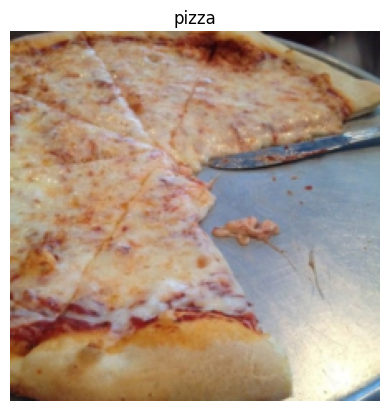

In [8]:
# get a batch of image
image_batch, label_batch = next(iter(train_dataloader))

# get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

plt.imshow(image.permute(1, 2, 0))  # (colour_channels, height, width) -> (height, width, colour_channels)
plt.title(class_names[label])
plt.axis(False)
plt.show()

## 3.0 Replicating ViT: Overview

So in order to make it more understandable, we cam break it down into smaller pieces:

* **Inputs** - What dows into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers.
* **Model** - A collection of blocks.

### 3.1 ViT overview: Pices of the puzzle

* Figure 1: Visual overview of the architecture.
* Four equations: Math equations which define the functions of each layer/block.
* Table 1/3: Different hyperparameters for the architecture/training.
* Text



<h3>Figure 1</h3>

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true"
height=400 width=800 alt="figure 1">



<h3>Four equations</h3>

$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$

<br>

<h3>Section 3.1 describes the various equations</h3>

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

<br>

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix (D.4). The resulting sequence of embedding vectors serves as input to the encoder.

<br>

**In psudocode:**

```python
x_input = [class_token, image_path_1, image_patch_2, ...image_patch_N] +
          [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... Image_patch_N_pos]
```



**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

<br>

In psudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```




**Equation 4:**
Similar to BERT's [class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

<br>

In psudocode:
```python
# Equaiton 4
y = MLP(LN_layer(x_output_MLP_block))
```



<h3>Table 1</h3>

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true" height=250 width=700 alt="table-1">

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers - The number of transformer encoder layers.
* Hidden size $D$ - The embedding size throughout the architecture.
* MLP size - The number of hidden units/neurons in the MLP.
* Head - The number of multi-head self-attention.

**🧮Embedding🧮:** It is a learnable representation of any data (number, text, image, code, video etc). Embeddings contains random numbers and it improves overtime.

## 4.0 Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?
> $H × W × C$ -> (height, width, colour_channels)

<br>

What's the output shape?
> Output shape: $N × (P^2 . C)$

* H = height
* W = width
* C = colour channels
* P = patch size
* N = number of patches = (height * width) / $p^2$
* D = constant latent vector size = embedding dimension (see Table 1)

In [9]:
# create a example values
height = 224
width = 224
colour_channels = 3
patch_size = 16

# calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
print(number_of_patches)

196


In [10]:
# input shape
embedding_layer_input_shape = (height, width, colour_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * colour_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.1 Truning a single image into patches

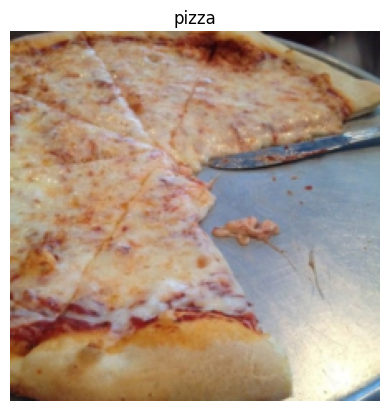

In [11]:
# view a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

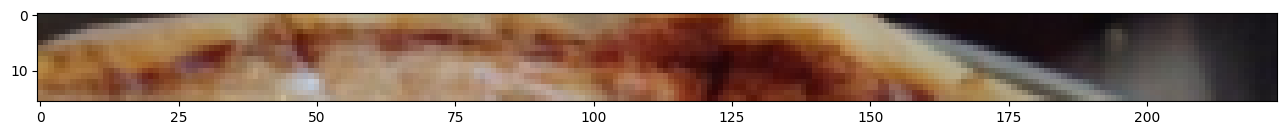

In [12]:
# lets get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.show()

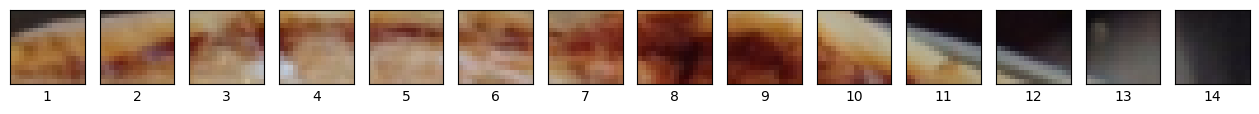

In [13]:
# setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# create a series of subplots
fig, axs = plt.subplots(figsize=(patch_size, patch_size),
                        nrows=1,
                        ncols=img_size // patch_size, # one column for each patches
                        sharex=True,
                        sharey=True)
# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)  # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row   : 14
Number of patches per column: 14
Total patches               : 196
Patch size                  : 16 pixels x 16 pixels


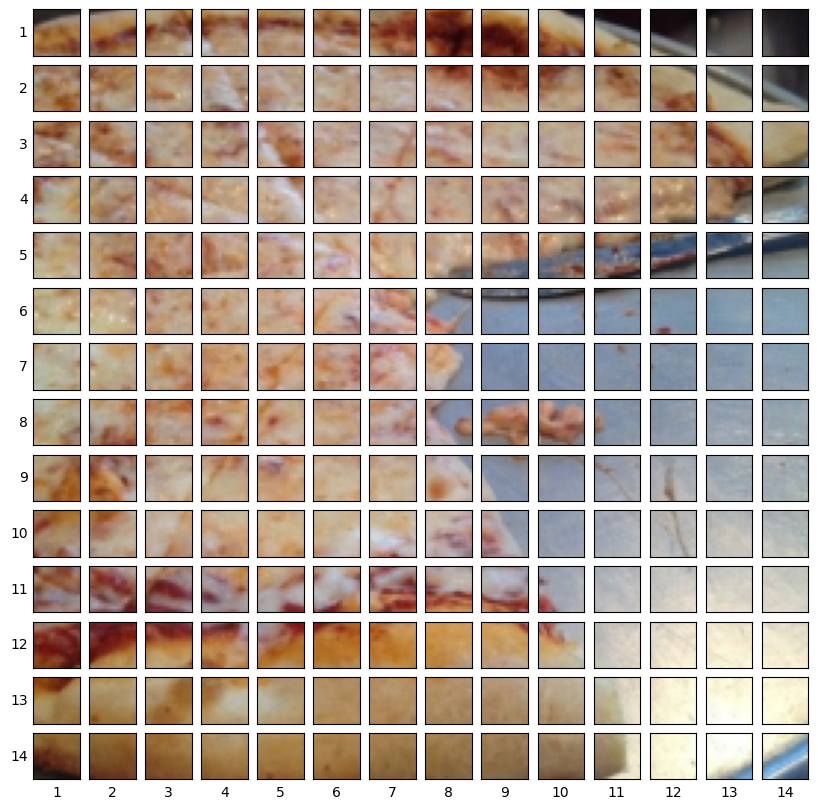

In [14]:
# ploting whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f'''Number of patches per row   : {num_patches}
Number of patches per column: {num_patches}
Total patches               : {num_patches * num_patches}
Patch size                  : {patch_size} pixels x {patch_size} pixels''')

# create a series of subplots
fig, axs = plt.subplots(figsize=(10, 10),
                        nrows=img_size // patch_size,
                        ncols=img_size // patch_size, # one column for each patches
                        sharex=True,
                        sharey=True)
# Iterate through height and width of the image
for i, patch_height, in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,  # iterate through height
                                    patch_width:patch_width+patch_size,  # iterate through width
                                    :])  # get all colour channels
    # setup label imformation for each subplot (patch)
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i, j].set_xlabel(j+1)  # set the patch label
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()
plt.show()

### 4.2 Creating image patches and turnig them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [15]:
# create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# set the patch size
path_size = 16

# create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [16]:
# pass the image through the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # adding a batch dimention to the image
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [17]:
# how a single feature map looks like
feature_map = image_out_of_conv[:, 0, :, :]
feature_map, feature_map.shape

(tensor([[[ 0.0206,  0.2335,  0.1330,  0.1842,  0.1351,  0.1157,  0.1228,
            0.0292,  0.2177,  0.2892, -0.0280, -0.0843,  0.0112,  0.0038],
          [ 0.1495,  0.1933,  0.2273,  0.2321,  0.2126,  0.2175,  0.2186,
            0.0574,  0.0408,  0.0884,  0.1465,  0.2205,  0.1695, -0.0007],
          [ 0.2213,  0.1529,  0.2441,  0.1775,  0.1803,  0.2493,  0.2200,
            0.2149,  0.2209,  0.2324,  0.2236,  0.1753,  0.2239,  0.2391],
          [ 0.1839,  0.2122,  0.1776,  0.2071,  0.2955,  0.2094,  0.2628,
            0.2068,  0.2660,  0.2137,  0.2675,  0.2031,  0.1484,  0.0549],
          [ 0.2368,  0.2325,  0.2357,  0.2101,  0.2518,  0.2668,  0.2522,
            0.2093,  0.2172,  0.2828,  0.0983,  0.0349,  0.1210,  0.0984],
          [ 0.1977,  0.1879,  0.2465,  0.2466,  0.2423,  0.2092,  0.1897,
            0.1053,  0.1682,  0.0803,  0.0858,  0.1924,  0.1988,  0.1735],
          [ 0.2309,  0.2528,  0.2028,  0.2043,  0.2734,  0.2054,  0.2150,
            0.1065,  0.1755,  0.

Showing random convolutional feature maps from indexes: [711, 684, 249, 336, 27]


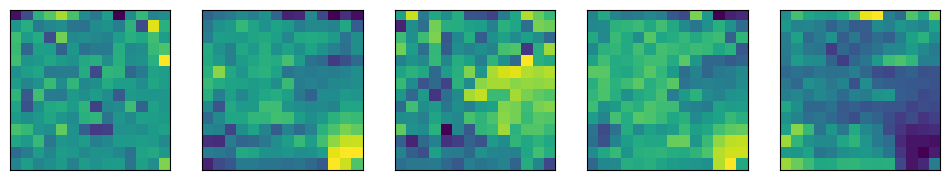

In [18]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]  # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())  # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### 4.3 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series of convolutional feature mmaps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [19]:
print(f'{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feture_map_width)')

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feture_map_width)


In [20]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_feature_map = flatten_layer(image_out_of_conv)

print(flatten_feature_map)
print(flatten_feature_map.shape)

# rearrange output of flattened layer
image_out_of_conv_flattened_permuted = flatten_feature_map.permute(0, 2, 1)
print(f'{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_paches, embedding_dimension)')

tensor([[[ 0.0206,  0.2335,  0.1330,  ...,  0.3198,  0.3181,  0.3260],
         [-0.4637, -0.4347, -0.4557,  ..., -1.1615, -1.1555, -0.9568],
         [ 0.0871,  0.1874,  0.1719,  ...,  0.4646,  0.4358,  0.3570],
         ...,
         [-0.6689, -0.6342, -0.8044,  ..., -1.5669, -1.4446, -1.2182],
         [-0.1457, -0.2149, -0.2195,  ..., -0.3189, -0.1589, -0.1985],
         [-0.3321, -0.3639, -0.4062,  ..., -0.7338, -0.5903, -0.2954]]],
       grad_fn=<ViewBackward0>)
torch.Size([1, 768, 196])
torch.Size([1, 196, 768]) -> (batch_size, number_of_paches, embedding_dimension)


In [21]:
# get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map

tensor([[ 0.0206,  0.2335,  0.1330,  0.1842,  0.1351,  0.1157,  0.1228,  0.0292,
          0.2177,  0.2892, -0.0280, -0.0843,  0.0112,  0.0038,  0.1495,  0.1933,
          0.2273,  0.2321,  0.2126,  0.2175,  0.2186,  0.0574,  0.0408,  0.0884,
          0.1465,  0.2205,  0.1695, -0.0007,  0.2213,  0.1529,  0.2441,  0.1775,
          0.1803,  0.2493,  0.2200,  0.2149,  0.2209,  0.2324,  0.2236,  0.1753,
          0.2239,  0.2391,  0.1839,  0.2122,  0.1776,  0.2071,  0.2955,  0.2094,
          0.2628,  0.2068,  0.2660,  0.2137,  0.2675,  0.2031,  0.1484,  0.0549,
          0.2368,  0.2325,  0.2357,  0.2101,  0.2518,  0.2668,  0.2522,  0.2093,
          0.2172,  0.2828,  0.0983,  0.0349,  0.1210,  0.0984,  0.1977,  0.1879,
          0.2465,  0.2466,  0.2423,  0.2092,  0.1897,  0.1053,  0.1682,  0.0803,
          0.0858,  0.1924,  0.1988,  0.1735,  0.2309,  0.2528,  0.2028,  0.2043,
          0.2734,  0.2054,  0.2150,  0.1065,  0.1755,  0.1816,  0.1692,  0.2069,
          0.1906,  0.2024,  

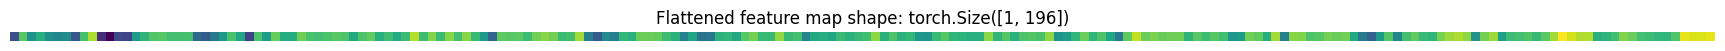

In [22]:
# plot the flattened feature map
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)
plt.show()

### 4.4 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:

1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding pathces using `nn.Conv2d`.
4. Create a layer to flatten the feature maps for the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer 3 and 4).
6. Make sure the output shape of the later reflects the required output shape of the patch embedding.

In [31]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int = 3,
               embedding_dim: int = 768,
               patch_size: int = 16):  # from table 1 ViT-base
    super().__init__()
    self.patch_size = patch_size
    self.patcher = nn.Sequential(
        # layer for turning image into embedded patches
        nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0),
        # layer to flatten the feature map outputs of Conv2d
        nn.Flatten(start_dim=2, end_dim=3)
    )

  def forward(self, x):
    # creating a assertion to check that inputs are in the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
    return self.patcher(x).permute(0, 2, 1)  # (batch_size, number_of_patches, embedding_dimension)

In [24]:
set_seeds()

# create a instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")

patch_embedded_image = patchify(image.unsqueeze(0))  # add a extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


### 4.5 creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [25]:
# get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [26]:
# create a class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [27]:
# add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number of patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Patch embedding shape with prepended class token: {patch_embedded_image_with_class_embedding.shape}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5910,  0.1058, -0.0333,  ...,  0.1634, -0.1392,  0.2608],
         [-0.6325,  0.2201, -0.0199,  ...,  0.2746, -0.3497,  0.1202],
         ...,
         [-0.9924,  0.2903, -0.2638,  ...,  0.7542, -0.4617,  0.3450],
         [-0.8791,  0.2300, -0.1697,  ...,  0.5660, -0.3721,  0.3249],
         [-0.4532,  0.0909, -0.2855,  ...,  0.5710, -0.3543,  0.2058]]],
       grad_fn=<CatBackward0>)
Patch embedding shape with prepended class token: torch.Size([1, 197, 768])


### 4.6 create the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [28]:
# clculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [29]:
# add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4090, 1.1058, 0.9667,  ..., 1.1634, 0.8608, 1.2608],
         [0.3675, 1.2201, 0.9801,  ..., 1.2746, 0.6503, 1.1202],
         ...,
         [0.0076, 1.2903, 0.7362,  ..., 1.7542, 0.5383, 1.3450],
         [0.1209, 1.2300, 0.8303,  ..., 1.5660, 0.6279, 1.3249],
         [0.5468, 1.0909, 0.7145,  ..., 1.5710, 0.6457, 1.2058]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.7 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's put it all in a single cell.

In [33]:
# set the seed
set_seeds()

# set the patch size
patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)   # make sure it is learnable
print(f"Class token embedding shape: {class_token.shape}")

# prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [34]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4090, 1.1058, 0.9667,  ..., 1.1634, 0.8608, 1.2608],
         [0.3675, 1.2201, 0.9801,  ..., 1.2746, 0.6503, 1.1202],
         ...,
         [0.0076, 1.2903, 0.7362,  ..., 1.7542, 0.5383, 1.3450],
         [0.1209, 1.2300, 0.8303,  ..., 1.5660, 0.6279, 1.3249],
         [0.5468, 1.0909, 0.7145,  ..., 1.5710, 0.6457, 1.2058]]],
       grad_fn=<AddBackward0>)

## 5.0 Equation 2: Multihead Self-Attention (MSA block)

**`Multihead self-attention`**: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.

To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

**`LayerNorm`**: It is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same standard deviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

Normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
  * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [37]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short)."""
  def __init__(self, embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:int=0):
    super().__init__()
    # create the norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # create the multihead self-attention layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
    return attn_output

In [42]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [43]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4090, 1.1058, 0.9667,  ..., 1.1634, 0.8608, 1.2608],
         [0.3675, 1.2201, 0.9801,  ..., 1.2746, 0.6503, 1.1202],
         ...,
         [0.0076, 1.2903, 0.7362,  ..., 1.7542, 0.5383, 1.3450],
         [0.1209, 1.2300, 0.8303,  ..., 1.5660, 0.6279, 1.3249],
         [0.5468, 1.0909, 0.7145,  ..., 1.5710, 0.6457, 1.2058]]],
       grad_fn=<AddBackward0>)

In [44]:
patched_image_through_msa_block

tensor([[[-0.1389,  0.0200, -0.6202,  ...,  0.1467,  0.2152,  0.4136],
         [-0.1489,  0.0296, -0.6159,  ...,  0.1513,  0.2159,  0.4105],
         [-0.1511,  0.0289, -0.6135,  ...,  0.1514,  0.2169,  0.4074],
         ...,
         [-0.1534,  0.0297, -0.6127,  ...,  0.1506,  0.2178,  0.4073],
         [-0.1525,  0.0291, -0.6132,  ...,  0.1488,  0.2185,  0.4072],
         [-0.1546,  0.0293, -0.6119,  ...,  0.1481,  0.2196,  0.4058]]],
       grad_fn=<TransposeBackward0>)